In [1]:
# %pip install transformer_lens # sae_lens
# %pip install matplotlib numpy scipy plotly pytest

# Setup

In [2]:
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from sae_lens.training.session_loader import LMSparseAutoencoderSessionloader
from huggingface_hub import hf_hub_download
from tqdm import tqdm
import numpy as np

In [3]:
# Start by downloading them from huggingface
device = "cuda"
REPO_ID = "jbloom/GPT2-Small-SAEs"

def get_sae(layer):
    assert 0<=layer<12, "Layer must be between 0 and 11"
    FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"

    # this is great because if you've already downloaded the SAE it won't download it twice!
    path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

    # We can then load the SAE, dataset and model using the session loader
    model, sparse_autoencoders, activation_store = (
        LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
    )
    assert len(list(sparse_autoencoders)) == 1, "There should only be one SAE in this file"
    return model, list(sparse_autoencoders)[0], activation_store

### Layer 8 SAE

In [4]:
model, sae_8, activation_store = get_sae(layer=8)
n_features = sae_8.cfg.d_sae

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/mnt/ssd-interp/stefan/hackathon/hackathon_env/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.


### Layer 9 SAE

In [5]:
model, sae_9, activation_store = get_sae(layer=9)
n_features = sae_9.cfg.d_sae

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/mnt/ssd-interp/stefan/hackathon/hackathon_env/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.


# Collect SAE feature activations

In [6]:
def get_feature_activation_table(sae, batches=100):
    layer = sae.cfg.hook_point_layer
    big_feature_activation_table = []
    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads
    for _ in tqdm(range(batches), desc=f"Getting activations for layer {layer}"):
        with torch.no_grad():
            batch_tokens = activation_store.get_batch_tokens()
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
            _, feature_acts, _, _, _, _ = sae(
                cache[sae.cfg.hook_point]
            )
            del cache
            big_feature_activation_table.append(feature_acts.view(-1, n_features).cpu())

    big_feature_activation_table = torch.cat(big_feature_activation_table, dim=0)
    return big_feature_activation_table

feature_activation_table_8 = get_feature_activation_table(sae_8)
feature_activation_table_9 = get_feature_activation_table(sae_9)

Getting activations for layer 9: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Text(0, 0.5, 'Histogram over total of 24576 features\nCut at x<100 because we want to make sure there are no low numbers')

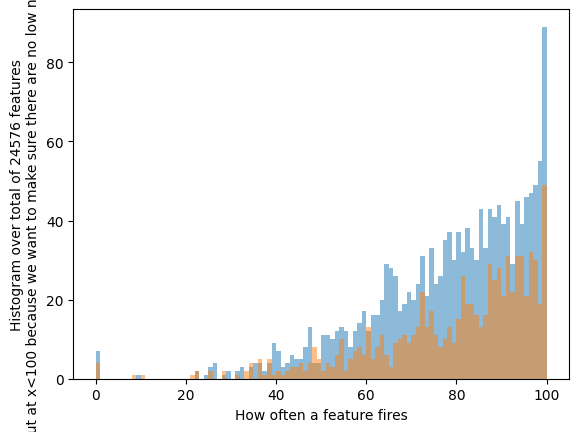

In [7]:
# Do we have a decent amount of activations for each feature?
plt.hist((feature_activation_table_8 != 0).sum(dim=0), range=(0, 100), bins=100, alpha=0.5)
plt.hist((feature_activation_table_9 != 0).sum(dim=0), range=(0, 100), bins=100, alpha=0.5)
plt.xlabel("How often a feature fires")
plt.ylabel(f"Histogram over total of {n_features} features\nCut at x<100 because we want to make sure there are no low numbers")

# Compute the correlations

In [10]:
# Compute correlation  between feature_activation_table_8 and feature_activation_table_9
# TESTING FIRST
feature_activation_table_8 = torch.rand(20, 100)
feature_activation_table_9 = torch.rand(20, 100)

correlation_matrix = np.corrcoef(feature_activation_table_8.T, feature_activation_table_9.T)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100 and the array at index 1 has size 20

In [11]:
correlation_matrix.shape

(200, 200)